In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import *
from darts.dataprocessing.transformers import Scaler


from darts.metrics import *
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [6]:
# Dataset suivi https://www.data.gouv.fr/fr/datasets/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/
link = 'https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5'

In [101]:
from egbz.utils import *

In [226]:
ts['hosp_dep'].plot()

KeyError: "not all values found in index 'component'"

In [227]:
ts = from_csv(link, cat_col=['dep'], time_col='date', value_cols='hosp')
ts

TypeError: read_csv() got an unexpected keyword argument 'cat_col'

In [97]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,01,2021-08-20,84,Ain,Auvergne et Rhône-Alpes,3.258138,165.764778,0.338104,NaN,78,...,627,189,2.0,0.0,0.0,0.0,14.0,162.0,1089.0,NaN
521,01,2021-08-21,84,Ain,Auvergne et Rhône-Alpes,3.222098,162.111560,0.339893,0.92,78,...,628,190,15.0,1.0,3.0,1.0,14.0,89.0,1065.0,NaN
522,01,2021-08-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.350626,NaN,78,...,628,196,8.0,0.0,0.0,0.0,9.0,NaN,NaN,NaN
523,01,2021-08-23,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.361360,NaN,76,...,628,202,0.0,0.0,3.0,0.0,31.0,NaN,NaN,58.8


In [169]:
time_col='date'
if time_col:
    datetime_series = pd.to_datetime(df[time_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df = df.set_index(datetime_index)
    df.drop(time_col, axis=1, inplace=True)

In [185]:
categories = itertools.product(*['dep', 'lib_dep'])
for x in categories:
    print(str(x))

('d', 'l')
('d', 'i')
('d', 'b')
('d', '_')
('d', 'd')
('d', 'e')
('d', 'p')
('e', 'l')
('e', 'i')
('e', 'b')
('e', '_')
('e', 'd')
('e', 'e')
('e', 'p')
('p', 'l')
('p', 'i')
('p', 'b')
('p', '_')
('p', 'd')
('p', 'e')
('p', 'p')


In [193]:
cat_cols = ['lib_dep']
value_cols = ['hosp']
categories = itertools.product(*[df[cat].unique() for cat in cat_cols])
d = {f'{col}_{"_".join([x for x in cat])}': 
     df.query(' & '.join([f'{cat_name}=="{cat_value}"'
                            for cat_name, cat_value in zip(cat_cols, [x for x in cat])
                            ])
     )[col]
    for cat in categories
    for col in value_cols
}
pd.DataFrame(d)

,hosp_Ain,hosp_Aisne,hosp_Allier,hosp_Alpes-de-Haute-Provence,hosp_Hautes-Alpes,hosp_Alpes-Maritimes,hosp_Ardèche,hosp_Ardennes,hosp_Ariège,hosp_Aube,...,hosp_Essonne,hosp_Hauts-de-Seine,hosp_Seine-Saint-Denis,hosp_Val-de-Marne,hosp_Val-d'Oise,hosp_Guadeloupe,hosp_Martinique,hosp_Guyane,hosp_Réunion,hosp_Mayotte
2020-03-18,2,41,4,3,8,25,12,0,1,5,...,51,149,92,122,90,0,16,0,2,0
2020-03-19,2,43,0,3,10,33,11,0,1,6,...,82,206,143,182,150,0,17,0,2,0
2020-03-20,2,52,1,3,13,43,15,1,2,12,...,122,254,201,226,192,0,19,0,2,0
2020-03-21,4,61,5,4,13,46,15,3,2,12,...,151,298,220,268,238,0,19,0,2,0
2020-03-22,8,69,5,4,14,45,22,4,2,21,...,196,378,263,306,281,6,19,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20,78,41,33,57,21,290,35,6,32,21,...,194,351,330,221,166,433,495,86,187,1
2021-08-21,78,42,27,50,24,283,32,9,28,20,...,202,350,331,226,170,441,502,86,188,1
2021-08-22,78,40,25,51,26,302,32,8,28,22,...,203,348,329,236,176,464,557,88,182,1
2021-08-23,76,37,25,54,31,316,32,8,36,26,...,208,350,353,235,171,476,591,89,191,1


In [208]:
from egbz.utils import *

<IPython.core.display.Javascript object>

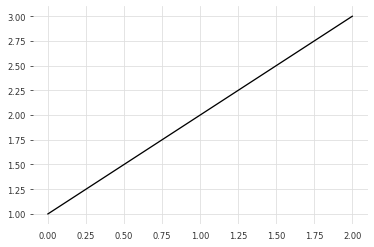

In [229]:
plt.plot([1, 2 ,3]);

In [220]:
df = df.query('dep=="01" | dep=="02"')

In [223]:
ts = from_df(df, cat_cols=['dep', 'lib_dep'], time_col='date', value_cols=['hosp', 'rea'])

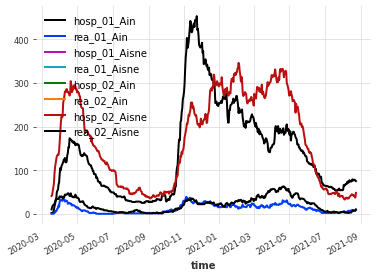

In [225]:
ts.plot()

In [133]:
import itertools

for x in itertools.product(*[df[cat].unique() for cat in ['dep', 'lib_dep']]):
    '_'.join([str(y) for y in x])

In [132]:
'test'
'trolol'

'trolol'

In [92]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,01,2021-08-20,84,Ain,Auvergne et Rhône-Alpes,3.258138,165.764778,0.338104,NaN,78,...,627,189,2.0,0.0,0.0,0.0,14.0,162.0,1089.0,NaN
521,01,2021-08-21,84,Ain,Auvergne et Rhône-Alpes,3.222098,162.111560,0.339893,0.92,78,...,628,190,15.0,1.0,3.0,1.0,14.0,89.0,1065.0,NaN
522,01,2021-08-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.350626,NaN,78,...,628,196,8.0,0.0,0.0,0.0,9.0,NaN,NaN,NaN
523,01,2021-08-23,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.361360,NaN,76,...,628,202,0.0,0.0,3.0,0.0,31.0,NaN,NaN,58.8


In [89]:
covid_df.query('dep=="01"')

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,01,2021-08-20,84,Ain,Auvergne et Rhône-Alpes,3.258138,165.764778,0.338104,NaN,78,...,627,189,2.0,0.0,0.0,0.0,14.0,162.0,1089.0,NaN
521,01,2021-08-21,84,Ain,Auvergne et Rhône-Alpes,3.222098,162.111560,0.339893,0.92,78,...,628,190,15.0,1.0,3.0,1.0,14.0,89.0,1065.0,NaN
522,01,2021-08-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.350626,NaN,78,...,628,196,8.0,0.0,0.0,0.0,9.0,NaN,NaN,NaN
523,01,2021-08-23,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.361360,NaN,76,...,628,202,0.0,0.0,3.0,0.0,31.0,NaN,NaN,58.8


In [219]:
df = covid_df
df

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53020,976,2021-08-20,6,Mayotte,Mayotte,1.256958,25.047322,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,8.0,70.0,NaN
53021,976,2021-08-21,6,Mayotte,Mayotte,1.199427,23.973865,0.000000,1.1,1,...,132,0,0.0,0.0,0.0,0.0,0.0,7.0,67.0,NaN
53022,976,2021-08-22,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
53023,976,2021-08-23,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.5


In [10]:
ts.pd_dataframe()

component,hosp_01,rea_01,hosp_02,rea_02,hosp_03,rea_03,hosp_04,rea_04,hosp_05,rea_05,...,hosp_971,rea_971,hosp_972,rea_972,hosp_973,rea_973,hosp_974,rea_974,hosp_976,rea_976
time,,,,,,,,,,,,,,,,,,,,,
2020-03-18,2.0,0.0,41.0,10.0,4.0,0.0,3.0,1.0,8.0,1.0,...,0.0,0.0,16.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0
2020-03-19,2.0,0.0,43.0,15.0,0.0,0.0,3.0,1.0,10.0,1.0,...,0.0,0.0,17.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0
2020-03-20,2.0,0.0,52.0,19.0,1.0,0.0,3.0,1.0,13.0,1.0,...,0.0,0.0,19.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0
2020-03-21,4.0,0.0,61.0,20.0,5.0,0.0,4.0,1.0,13.0,1.0,...,0.0,0.0,19.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0
2020-03-22,8.0,1.0,69.0,21.0,5.0,0.0,4.0,1.0,14.0,1.0,...,6.0,6.0,19.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-20,78.0,8.0,41.0,7.0,33.0,5.0,57.0,5.0,21.0,2.0,...,433.0,71.0,495.0,122.0,86.0,22.0,187.0,42.0,1.0,0.0
2021-08-21,78.0,8.0,42.0,7.0,27.0,5.0,50.0,3.0,24.0,5.0,...,441.0,70.0,502.0,120.0,86.0,23.0,188.0,44.0,1.0,0.0
2021-08-22,78.0,8.0,40.0,7.0,25.0,4.0,51.0,3.0,26.0,6.0,...,464.0,71.0,557.0,126.0,88.0,25.0,182.0,40.0,1.0,0.0


In [7]:
covid_df = pd.read_csv(link)

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
covid_df

NameError: name 'covid_df' is not defined

In [10]:
d = {f'{cat}_{col}': cat for cat in covid_df['dep'].unique() for col in ['hosp']}
d

{'01_hosp': '01',
 '02_hosp': '02',
 '03_hosp': '03',
 '04_hosp': '04',
 '05_hosp': '05',
 '06_hosp': '06',
 '07_hosp': '07',
 '08_hosp': '08',
 '09_hosp': '09',
 '10_hosp': '10',
 '11_hosp': '11',
 '12_hosp': '12',
 '13_hosp': '13',
 '14_hosp': '14',
 '15_hosp': '15',
 '16_hosp': '16',
 '17_hosp': '17',
 '18_hosp': '18',
 '19_hosp': '19',
 '21_hosp': '21',
 '22_hosp': '22',
 '23_hosp': '23',
 '24_hosp': '24',
 '25_hosp': '25',
 '26_hosp': '26',
 '27_hosp': '27',
 '28_hosp': '28',
 '29_hosp': '29',
 '2A_hosp': '2A',
 '2B_hosp': '2B',
 '30_hosp': '30',
 '31_hosp': '31',
 '32_hosp': '32',
 '33_hosp': '33',
 '34_hosp': '34',
 '35_hosp': '35',
 '36_hosp': '36',
 '37_hosp': '37',
 '38_hosp': '38',
 '39_hosp': '39',
 '40_hosp': '40',
 '41_hosp': '41',
 '42_hosp': '42',
 '43_hosp': '43',
 '44_hosp': '44',
 '45_hosp': '45',
 '46_hosp': '46',
 '47_hosp': '47',
 '48_hosp': '48',
 '49_hosp': '49',
 '50_hosp': '50',
 '51_hosp': '51',
 '52_hosp': '52',
 '53_hosp': '53',
 '54_hosp': '54',
 '55_hosp'

In [20]:
TimeSeries.from_dataframe(covid_df[['dep','hosp']].query('dep=="01"'))

<TimeSeries (DataArray) (date: 525, component: 2, sample: 1)>
array([[[ 1.],
        [ 2.]],

       [[ 1.],
        [ 2.]],

       [[ 1.],
        [ 2.]],

       ...,

       [[ 1.],
        [78.]],

       [[ 1.],
        [76.]],

       [[ 1.],
        [75.]]])
Coordinates:
  * date       (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-24
  * component  (component) object 'dep' 'hosp'
Dimensions without coordinates: sample

In [7]:
from darts import TimeSeries

In [10]:
TimeSeries.from_dataframe(covid_df[covid_df['dep']=='01'],
                         time_col='date',
                         value_cols='hosp')

<TimeSeries (DataArray) (date: 525, component: 1, sample: 1)>
array([[[  2.]],

       [[  2.]],

       [[  2.]],

       [[  4.]],

       [[  8.]],

       [[ 17.]],

       [[ 22.]],

       [[ 29.]],

       [[ 33.]],

       [[ 49.]],

...

       [[ 74.]],

       [[ 74.]],

       [[ 76.]],

       [[ 79.]],

       [[ 76.]],

       [[ 78.]],

       [[ 78.]],

       [[ 78.]],

       [[ 76.]],

       [[ 75.]]])
Coordinates:
  * date       (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-24
  * component  (component) object 'hosp'
Dimensions without coordinates: sample

In [38]:
covid_df.keys()

Index(['dep', 'date', 'reg', 'lib_dep', 'lib_reg', 'tx_pos', 'tx_incid', 'TO',
       'R', 'hosp', 'rea', 'rad', 'dchosp', 'reg_rea', 'incid_hosp',
       'incid_rea', 'incid_rad', 'incid_dchosp', 'reg_incid_rea', 'pos',
       'pos_7j', 'cv_dose1'],
      dtype='object')

In [42]:
covid_df.groupby('dep').

In [30]:
paris_df = covid_df.query('dep==75')

In [79]:
df = covid_df[['date', 'dep', 'dchosp', 'hosp', 'rea']]
datetime_series = pd.to_datetime(df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

,dep,dchosp,hosp,rea
2020-03-18,01,0,2,0
2020-03-19,01,0,2,0
2020-03-20,01,0,2,0
2020-03-21,01,0,4,0
2020-03-22,01,0,8,1
...,...,...,...,...
2021-08-19,976,132,1,0
2021-08-20,976,132,1,0
2021-08-21,976,132,1,0
2021-08-22,976,132,1,0


In [34]:
def series_train_test(
    data=covid_df, features=['hosp'],
    timestamp=pd.Timestamp('2021-01-01'), departement=75
):
    # Convert the index into a datetime index
    df = covid_df.query(f'dep=={departement}')[['date'] + features]
    datetime_series = pd.to_datetime(df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df=df.set_index(datetime_index)
    df.drop('date',axis=1,inplace=True)
    
    #
    time_series = {}
    train = {}
    test = {}
    for feature in features:
      series[feature] = TimeSeries.from_dataframe(df[[feature]]) 
      train[feature], test[feature] = time_series[feature].split_before(
          pd.Timestamp(timestamp)
      )
        
    return series, train, test

In [35]:
time_series, train, test = time_series_train_test(data=paris_df, features['rea'])

SyntaxError: positional argument follows keyword argument (3796427371.py, line 1)

In [29]:
covid_df

,dep,date,reg,lib_dep,lib_reg,tx_pos,tx_incid,TO,R,hosp,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
0,01,2020-03-18,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.062612,NaN,2,...,0,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-03-19,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.132379,NaN,2,...,0,79,1.0,0.0,0.0,0.0,44.0,NaN,NaN,NaN
2,01,2020-03-20,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.155635,NaN,2,...,0,87,0.0,0.0,1.0,0.0,16.0,NaN,NaN,NaN
3,01,2020-03-21,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.173524,NaN,4,...,0,88,3.0,0.0,0.0,0.0,15.0,NaN,NaN,NaN
4,01,2020-03-22,84,Ain,Auvergne et Rhône-Alpes,NaN,NaN,0.212880,NaN,8,...,0,106,3.0,1.0,1.0,0.0,25.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,976,2021-08-19,6,Mayotte,Mayotte,1.285874,24.689503,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,13.0,69.0,NaN
52920,976,2021-08-20,6,Mayotte,Mayotte,1.256958,25.047322,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,8.0,70.0,NaN
52921,976,2021-08-21,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
52922,976,2021-08-22,6,Mayotte,Mayotte,NaN,NaN,0.000000,NaN,1,...,132,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.3


In [7]:
time_series['dchosp']

NameError: name 'time_series' is not defined

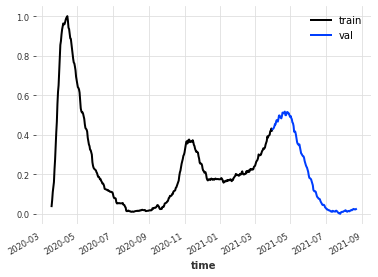

In [69]:
train['hosp'].plot(label='train')
test['hosp'].plot(label='test')

In [3]:
paris_df = covid_df.query('dep==75')[['date', 'TO', 'hosp', 'rea', 'dchosp']]

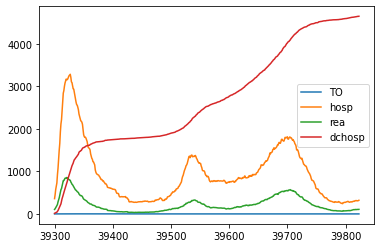

In [6]:
paris_df.plot();

In [11]:
paris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 39225 to 39747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    523 non-null    object 
 1   TO      523 non-null    float64
 2   hosp    523 non-null    int64  
 3   rea     523 non-null    int64  
 4   dchosp  523 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 24.5+ KB


In [4]:
datetime_series = pd.to_datetime(paris_df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=paris_df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

,TO,hosp,rea,dchosp
2020-03-18,0.256321,359,105,14.0
2020-03-19,0.357454,453,122,22.0
2020-03-20,0.421970,575,145,30.0
2020-03-21,0.494333,649,165,36.0
2020-03-22,0.580645,728,195,40.0
...,...,...,...,...
2021-08-18,0.346992,316,101,4634.0
2021-08-19,0.355711,310,103,4636.0
2021-08-20,0.362685,310,105,4639.0
2021-08-21,0.367044,308,104,4642.0


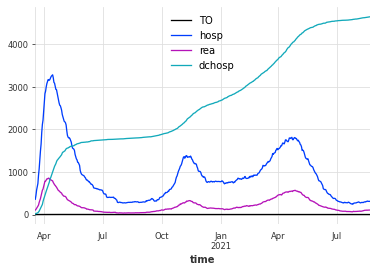

In [ ]:

df.plot();

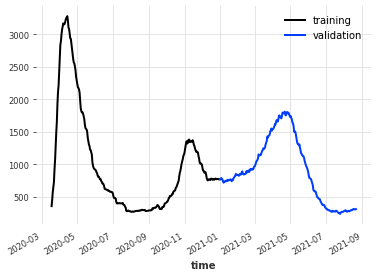

In [ ]:
train, val = series.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

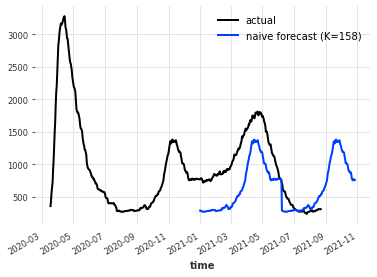

In [86]:
naive_model = NaiveSeasonal(K=158)
naive_model.fit(train)
naive_forecast = naive_model.predict(300)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=158)')
plt.legend();

In [75]:
mae(naive_model.predict(220), val)

491.82272727272726

In [59]:
!pip install optuna

     |████████████████████████████████| 302 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 164 kB 48.4 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 111 kB 50.8 MB/s 
     |████████████████████████████████| 141 kB 53.1 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=fab4e0e86b78016afe11bd2b557f0fd128a1f37bdaff70b84a70098070e8e8ad
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [60]:
import optuna

In [80]:
def objective(trial):
  naive_model = NaiveSeasonal(K=trial.suggest_int('K', 1, 289))
  naive_model.fit(train)
  return mae(naive_model.predict(220), val)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=289, n_jobs=-1)


In [81]:
study.best_trial

FrozenTrial(number=111, values=[398.6909090909091], datetime_start=datetime.datetime(2021, 8, 23, 12, 11, 34, 46160), datetime_complete=datetime.datetime(2021, 8, 23, 12, 11, 34, 113070), params={'K': 158}, distributions={'K': IntUniformDistribution(high=289, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=111, state=TrialState.COMPLETE, value=None)

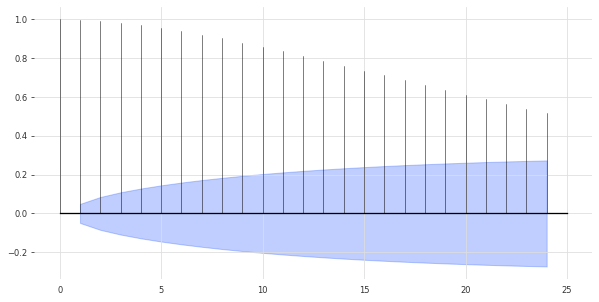

In [88]:
plot_acf(train, m = 30, alpha = .05)

In [103]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAE: {:.2f}%'.format(model, mae(val, forecast)))

eval_model(NaiveSeasonal(K=158))
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Naive seasonal model, with K=158 obtains MAE: 384.04%
model Exponential smoothing obtains MAE: 412.10%
model Prophet obtains MAE: 819.33%
model Auto-ARIMA obtains MAE: 426.69%
model Theta(2) obtains MAE: 417.35%


18.85361017566447

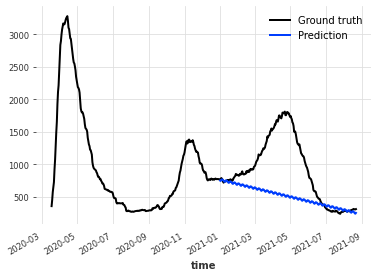

In [101]:
expo_model = ExponentialSmoothing()
expo_model.fit(train)
expo_forecast = expo_model.predict(len(val))
series.plot(label='Ground truth')
expo_forecast.plot(label='Prediction')
mae(y_pred, val)

In [104]:
def objective(trial):
  theta_model = Theta(theta=trial.suggest_float('theta', -10, 10))
  theta_model.fit(train)
  theta_forecast = theta_model.predict(len(val))
  return mae(theta_forecast, val)

theta_study = optuna.create_study(direction='minimize')
theta_study.optimize(objective, n_trials=500, n_jobs=-1)

In [106]:
theta_study.trials_dataframe().sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_theta,state
462,462,401.005426,2021-08-23 12:41:19.817875,2021-08-23 12:41:19.920037,0 days 00:00:00.102162,1.422738,COMPLETE
146,146,401.006341,2021-08-23 12:41:03.926174,2021-08-23 12:41:03.990563,0 days 00:00:00.064389,1.424205,COMPLETE
481,481,401.009079,2021-08-23 12:41:20.715615,2021-08-23 12:41:20.817185,0 days 00:00:00.101570,1.421055,COMPLETE
339,339,401.009150,2021-08-23 12:41:13.611698,2021-08-23 12:41:13.703927,0 days 00:00:00.092229,1.428599,COMPLETE
494,494,401.015493,2021-08-23 12:41:21.376529,2021-08-23 12:41:21.470393,0 days 00:00:00.093864,1.418863,COMPLETE
...,...,...,...,...,...,...,...
31,31,7975.172726,2021-08-23 12:40:58.483390,2021-08-23 12:40:58.577495,0 days 00:00:00.094105,0.063315,COMPLETE
78,78,8738.235269,2021-08-23 12:41:00.700988,2021-08-23 12:41:00.791075,0 days 00:00:00.090087,0.058187,COMPLETE
79,79,11941.519766,2021-08-23 12:41:00.746946,2021-08-23 12:41:00.844691,0 days 00:00:00.097745,0.043422,COMPLETE
413,413,17886.211616,2021-08-23 12:41:17.334871,2021-08-23 12:41:17.433662,0 days 00:00:00.098791,-0.031860,COMPLETE


18.85361017566447

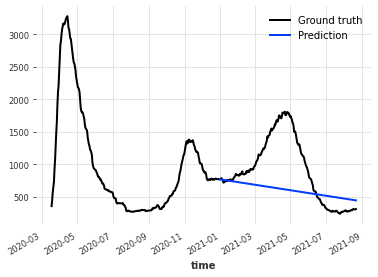

In [107]:
theta_model = Theta(theta=1.422738)
theta_model.fit(train)
theta_forecast = theta_model.predict(len(val))
theta_forecast = theta_model.predict(len(val))
series.plot(label='Ground truth')
theta_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
df.keys()

In [5]:
time_series = {}
train_val = {}
for feature in df.keys():
  time_series[feature] = Scaler().fit_transform(TimeSeries.from_dataframe(df[[feature]]))
  train_val[feature] = time_series[feature].split_before(pd.Timestamp('2021-01-01'))

In [100]:
time_series, train, test = time_series_train_val(timestamp='2021-04-01', features=['hosp', 'rea'])

In [80]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=12)

In [81]:
model_air.fit(train['hosp'], verbose=True)

  0%|          | 0/12 [00:00<?, ?it/s]

32.39865229124566

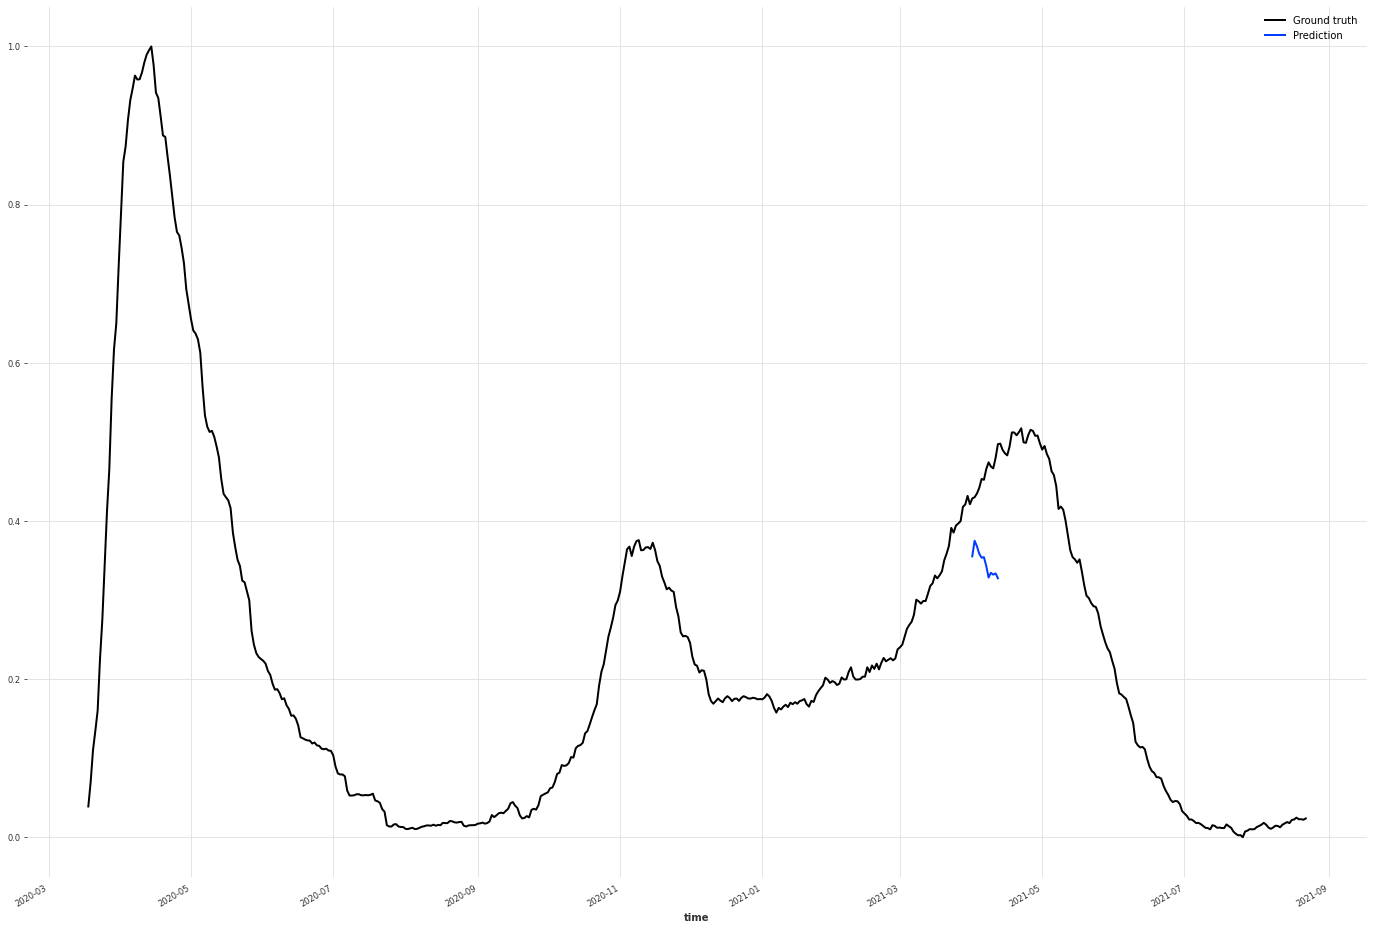

In [82]:
air_forecast = model_air.predict(12)
plt.figure(figsize=(24,16))
time_series['hosp'].plot(label='Ground truth')
air_forecast.plot(label='Prediction')
mape(air_forecast, time_series['hosp'])

In [189]:
series, train, test = time_series_train_val(
    timestamp=pd.Timestamp('2021-07-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [190]:
train_series, train, val = time_series_train_val(
    data=train,
    timestamp=pd.Timestamp('2021-01-01'),
    features=['hosp', 'rea', 'dchosp']
)

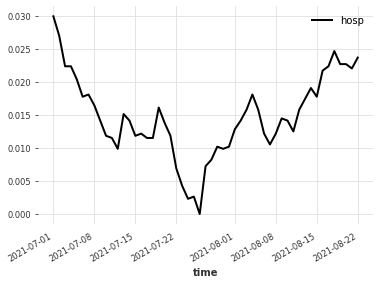

In [199]:
test['hosp'].plot()

In [180]:
my_model = TransformerModel(
    input_chunk_length = 20,
    output_chunk_length = 10,
    batch_size = 16,
    n_epochs = 50,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    force_reset=True
)

In [181]:
my_model.fit(series=train['hosp'], val_series=val['hosp'], verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

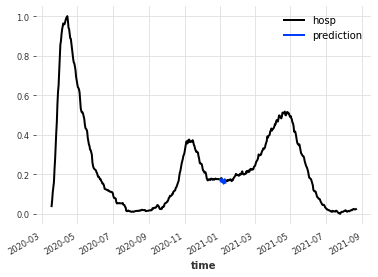

In [197]:
pred = my_model.predict(n=10, series=train['hosp'])
series['hosp'].plot('label')
pred.plot(label='prediction')

In [ ]:
backtest = model_cov.historical_forecasts(series_air_scaled,
                                              past_covariates=air_covariates,
                                              start=0.6,
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_air_scaled, backtest_cov)))

ValueError: The time series array must not be empty.

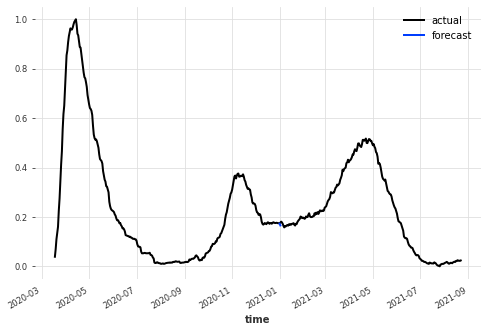

In [186]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend();

eval_model(my_model, 2, series['hosp'], test['hosp'])
